# Large-Scale Dataset Pruning with Dynamic Uncertainty for MNIST

Implementation according to "Large-scale Dataset Pruning with Dynamic Uncertainty" (https://arxiv.org/abs/2306.05175)

**Objective:**

    "Implement data pruning using the dynamic uncertainty score on the MNIST dataset and train a model with 25% and 50% pruning (i.e., 25% or 50% of the data is removed for the final training using the calculated pruning scores). Compare your implementation with random subsampling of the data. Additionally, implement the following custom dynamic uncertainty score U(x) = abs(DFT(x)), where DFT is the Discrete Fourier Transform and abs takes the magnitude of the frequency spectrum. Consider the following: Do we need every value of the DFT, or can we remove some and get the same result? If we only want to consider the dynamics, which values do we need to remove? "

In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Subset

from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np

from tqdm import tqdm

/home/linus/miniconda3/envs/adl4r/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 32
pruning_ratio = 0.25
epochs = 10
crit = nn.CrossEntropyLoss()
J = 5 # J < epochs

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


---

In [11]:
# Eval accuracy of a given net on a given loader
def eval_acc(net : nn.Module, loader : DataLoader):
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:# tqdm(loader, desc=f'Test acc'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [12]:
# Train network
def train(net : nn.Module, epochs: int, trainloader: DataLoader, valloader : DataLoader):
    optimizer = AdamW(net.parameters())
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{epochs}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = crit(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / (trainloader.batch_size*len(trainloader))
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}')
        print(f'Train Accuracy: {eval_acc(net=net, loader=trainloader) * 100:.2f}%')
        print(f'Validation Accuracy: {eval_acc(net=net, loader=valloader) * 100:.2f}%')
    return net

---

Build Model

In [13]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(in_features=14*14*16, out_features=10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # x = self.softmax(x)
        return x
    
# Test model 
x_random = torch.randn((2,1,28,28))
net = CNN()
print(net(x_random))
del net

tensor([[ 0.0701,  0.2331, -0.3286, -0.0345,  0.0113, -0.2889,  0.0658, -0.2704,
         -0.0313,  0.3050],
        [ 0.0717,  0.3943, -0.1504, -0.1216, -0.1051, -0.2747, -0.1904, -0.2426,
         -0.1462,  0.1884]], grad_fn=<AddmmBackward0>)


Load dataset

In [14]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)) # Mean and std of MNIST dataset
        ])

trainset = MNIST(root='../data', train=True, download=True, transform=transform)
testset = MNIST(root='../data', train=False, download=True, transform=transform)

# Just shuffle once initially!
indices = torch.randperm(len(trainset))
train_size = int(0.8 * len(indices))
val_size = len(indices) - train_size
subset_size = int((1 - pruning_ratio) * train_size)
train_indices, val_indices = indices[:train_size], indices[train_size:]

train_subset = Subset(trainset, train_indices)
val_subset = Subset(trainset, val_indices)

trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
valloader =  DataLoader(val_subset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [15]:
print(f"Trainset size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Subset size: {subset_size}")
print(f"Teset size: {len(testset)}")

Trainset size: 48000
Validation size: 12000
Subset size: 36000
Teset size: 10000


---

**Baseline** (full dataset)

In [16]:
net_baseline = CNN()
net_baseline = net_baseline.to(device)
name_baseline = f"baseline_{epochs}"

In [17]:
net_baseline = train(net=net_baseline, epochs=epochs, trainloader=trainloader, valloader=valloader)
print(f'Test Accuracy: {eval_acc(net=net_baseline, loader=testloader) * 100:.2f}%')

Epoch 1/10: 100%|██████████| 1500/1500 [00:37<00:00, 40.37it/s]


Epoch 1/10, Average Loss: 0.0052
Train Accuracy: 97.92%
Validation Accuracy: 97.42%


Epoch 2/10: 100%|██████████| 1500/1500 [00:44<00:00, 33.84it/s]


Epoch 2/10, Average Loss: 0.0021
Train Accuracy: 98.63%
Validation Accuracy: 97.85%


Epoch 3/10: 100%|██████████| 1500/1500 [00:37<00:00, 40.47it/s]


Epoch 3/10, Average Loss: 0.0015
Train Accuracy: 98.91%
Validation Accuracy: 98.22%


Epoch 4/10:   7%|▋         | 102/1500 [00:02<00:34, 40.02it/s]


KeyboardInterrupt: 

In [176]:
torch.save(net_baseline.state_dict(), f"../models/{name_baseline}.pth")

---

**Random Subsampling**

In [177]:
net_subsampling = CNN()
net_subsampling = net_subsampling.to(device)
name_subsampling = f"subsampling_{pruning_ratio}_{epochs}"

In [178]:
from torch.utils.data import SubsetRandomSampler
idxs = torch.randperm(train_size)[:subset_size]
sampler = SubsetRandomSampler(idxs)
randomsubsampledloader = DataLoader(trainloader.dataset, batch_size=batch_size, sampler=sampler)

In [ ]:
net_baseline = train(net=net_subsampling, epochs=epochs, trainloader=randomsubsampledloader, valloader=valloader)
print(f'Test Accuracy: {eval_acc(net=net_subsampling, loader=testloader) * 100:.2f}%')

In [180]:
torch.save(net_subsampling.state_dict(), f"../models/{name_subsampling}.pth")

Test acc: 100%|██████████| 313/313 [00:03<00:00, 83.85it/s]

Test Accuracy: 98.43%


---

**With Pruning**

In [181]:
net_pruning = CNN()
optimizer_pruning = AdamW(net_pruning.parameters())

In [182]:
# Algorithm 1: Dataset pruning with dynamic uncertainty.
# Input: Trainingset - trainloader, pruning ratio: pruning_ratio
# Required Model: net_pruning, traing epochs: epochs, uncertainty window: J

# To track uncertainty
uncertainty_window = np.zeros((train_size, J)) # Uncertainty window
uncertainty_EQ2 = np.zeros((train_size, epochs-J+1)) # Uncertainty according to Eq.2
uncertainty = np.zeros(train_size) # Overall uncertainty according to Eq.3

# for k = 0, · · · , K − 1 do
for epoch in range(epochs):
    total_loss = 0.0
    idx = 0
    
    # Sample a batch B ∼ T.
    # for (xi, yi) ∈ B do:
    for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{epochs}'):
        optimizer_pruning.zero_grad()

        # Compute prediction P(yi, xi, θ) and loss ℓ(ϕθ(A(xi)), yi)
        outputs = net_pruning(inputs)
        loss = crit(outputs, labels)

        # Store window
        predicted_values = outputs[range(outputs.size(0)), labels]
        uncertainty_window[idx:idx+len(labels), epoch%J] = predicted_values.detach().numpy()
        idx += len(labels)

        # Update θ ← θ − η∇θL, where L =Σℓ(ϕθ(A(xi)),yi) / |B|
        loss.backward()
        optimizer_pruning.step()
        total_loss += loss.item()

    # if k ≥ J then
        # Compute uncertainty Uk−J (xi) using Eq. 2
    if epoch >= J-1:
            U_epoch = np.std(uncertainty_window, ddof=1, axis=1)
            uncertainty_EQ2[:, epoch-J+1] = U_epoch

    average_loss = total_loss / subset_size
    print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}')

# for (xi, yi) ∈ T do
    # Compute dynamic uncertainty U(xi) using Eq. 3
uncertainty = np.mean(uncertainty_EQ2, axis=1)

# Sort T in the descending order of U(·)
sorted_indices = np.argsort(uncertainty)[::-1]

# S ← front (1 − r) × |T | samples in the sorted T
subset_indices = sorted_indices[:int(len(sorted_indices)*(1-pruning_ratio))]

# Output: Pruned dataset S
train_dynamic_uncertainty_subset = Subset(dataset=trainloader.dataset, indices=subset_indices)

Epoch 1/10:  43%|████▎     | 652/1500 [00:13<00:25, 33.90it/s]

Epoch 1/10: 100%|██████████| 1500/1500 [00:43<00:00, 34.20it/s]


Epoch 1/10, Average Loss: 0.0067


Epoch 2/10: 100%|██████████| 1500/1500 [00:37<00:00, 40.37it/s]


Epoch 2/10, Average Loss: 0.0027


Epoch 3/10: 100%|██████████| 1500/1500 [00:33<00:00, 44.65it/s]


Epoch 3/10, Average Loss: 0.0019


Epoch 4/10: 100%|██████████| 1500/1500 [00:33<00:00, 44.68it/s]


Epoch 4/10, Average Loss: 0.0014


Epoch 5/10: 100%|██████████| 1500/1500 [00:33<00:00, 44.20it/s]


Epoch 5/10, Average Loss: 0.0011


Epoch 6/10: 100%|██████████| 1500/1500 [00:33<00:00, 44.14it/s]


Epoch 6/10, Average Loss: 0.0008


Epoch 7/10: 100%|██████████| 1500/1500 [00:34<00:00, 43.50it/s]


Epoch 7/10, Average Loss: 0.0007


Epoch 8/10: 100%|██████████| 1500/1500 [00:34<00:00, 43.44it/s]


Epoch 8/10, Average Loss: 0.0005


Epoch 9/10: 100%|██████████| 1500/1500 [00:34<00:00, 43.39it/s]


Epoch 9/10, Average Loss: 0.0005


Epoch 10/10: 100%|██████████| 1500/1500 [00:34<00:00, 43.59it/s]

Epoch 10/10, Average Loss: 0.0004


In [183]:
net_pruning = CNN()
net_pruning = net_pruning.to(device)
name_pruning = f"pruning_{pruning_ratio}_{epochs}"
dynamic_uncertainty = DataLoader(train_dynamic_uncertainty_subset, batch_size=batch_size, shuffle=False)

In [ ]:
net_baseline = train(net=net_pruning, epochs=epochs, trainloader=dynamic_uncertainty, valloader=valloader)
print(f'Test Accuracy: {eval_acc(net=net_pruning, loader=testloader) * 100:.2f}%')

In [185]:
torch.save(net_pruning.state_dict(), f"../models/{name_pruning}.pth")

Test acc: 100%|██████████| 313/313 [00:05<00:00, 61.59it/s]

Test Accuracy: 97.93%


---

**Discrete Fourier Transform**

Additionally, implement the following custom dynamic uncertainty score U(x) = abs(DFT(x)), where DFT is the Discrete Fourier Transform and abs takes the magnitude of the frequency spectrum. Consider the following: Do we need every value of the DFT, or can we remove some and get the same result? If we only want to consider the dynamics, which values do we need to remove? "

Magnitude spectrum: abs(fft2d())

In [48]:
import matplotlib.pyplot as plt

from torch.fft import fft, fft2

In [49]:
num_row = 2
num_col = 5
num = 10

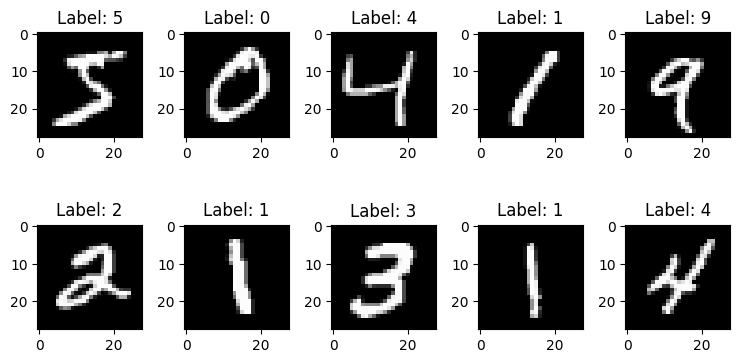

In [50]:
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset[i][0][0,:,:], cmap='gray')
    ax.set_title('Label: {}'.format(trainset[i][1]))
plt.tight_layout()
plt.show()

2D FFT

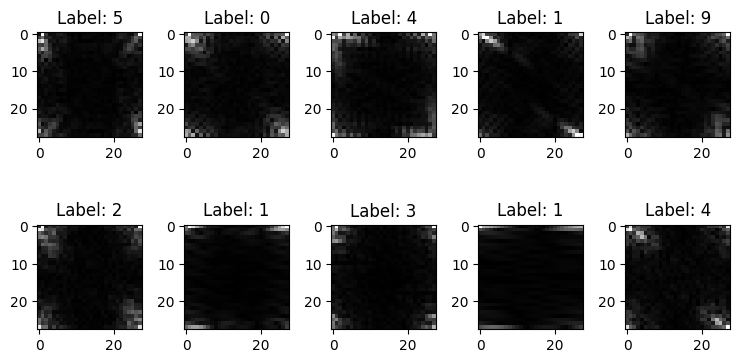

In [96]:
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(fft2(input=trainset[i][0][0,:,:]).abs(), cmap='gray')
    ax.set_title('Label: {}'.format(trainset[i][1]))
plt.tight_layout()
plt.show()

In [107]:
for j in range(500):
    print(fft2(input=trainset[j][0][0,:,:]).abs().numpy()[14,14])

4.1112194
2.863854
5.180392
3.4748092
3.0802321
1.6673982
0.5345864
0.26729345
3.589361
3.2329712
5.778619
2.5456467
0.39457464
1.5146592
0.38184738
2.4183626
1.3110082
2.774754
3.0675054
0.050913095
1.7946815
0.5727711
0.674597
1.4892029
2.392907
0.85279065
1.2346387
1.5783004
3.3857098
9.50799
1.0182575
0.54731345
0.14001179
2.1892555
2.9656777
0.6364109
3.2202437
1.170996
3.6275473
2.2147126
0.59822667
9.151602
0.089096725
3.0547767
7.331462
0.5345856
3.818471
1.6419413
3.8439267
1.2219102
4.3912416
4.467609
1.3237365
3.105689
2.54565
5.104023
0.07637203
0.47094342
0.4454875
0.43276036
0.56004286
0.3054788
4.9131002
2.0492449
1.298279
1.1073551
2.4310927
1.5528445
4.353056
2.5838344
4.047578
0.636412
1.578301
2.9911366
1.6673965
3.5257196
1.6673999
0.3436613
0.42002946
6.058639
10.920826
4.7349024
0.54731417
8.120613
3.0547757
1.0946276
2.0874305
0.43275973
2.418365
7.738768
2.061974
12.448214
5.549511
1.8583217
2.1001596
3.0165896
1.2346389
3.5639052
2.1510696
2.660201
0.012729168


In [120]:
x = next(iter(trainloader))[0]
x = fft2(input=x[:,0,:,:]).abs().numpy()

In [140]:
np.mean(x, axis=0)[27,26]

90.05233